## Case 01: Variational Autoencoder (VAE)
* Dataset: CIFAR100
* DL Framework: Tensorflow-Keras
* DL Task: Image reconstruction

`PREREQUISITE` All modules (with their suitable versions) are installed properly.
<br>`TASK` Complete the notebook cell's code marked with <b>#TODO</b> comment.
<br>`OBJECTIVE` Achieve a min. validation accuracy of <b>90%</b> within <b>10 epochs</b>.
<br>`WARNING` Do <b>NOT</b> change any codes in the <i>config.ipynb</i> file.

### Import libraries

In [1]:
#from ipynb.fs.full.config import init, load_cifar_100_data, accuracy, show_reconstructions

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle

import keras

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Lambda, MaxPooling2D
from keras import metrics


from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU

from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import Add, Multiply

from keras.layers import Flatten
from keras.layers import Reshape
#from keras.losses import SparseCategoricalCrossentropy

from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

import tqdm
import os
import cv2
import numpy as np

from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from matplotlib import pyplot as plt

# https://keras.io/examples/generative/vae/
# https://olaralex.com/variational-auto-encoder-with-cifar-10-2/

Using TensorFlow backend.


### Load the dataset

In [2]:
x_train = pickle.load(open('../input/cifar10/x_train.pkl', 'rb'))
y_train = pickle.load(open('../input/cifar10/y_train.pkl', 'rb'))

x_test = pickle.load(open('../input/cifar10/x_test.pkl', 'rb'))
y_test = pickle.load(open('../input/cifar10/y_test.pkl', 'rb'))

In [3]:
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

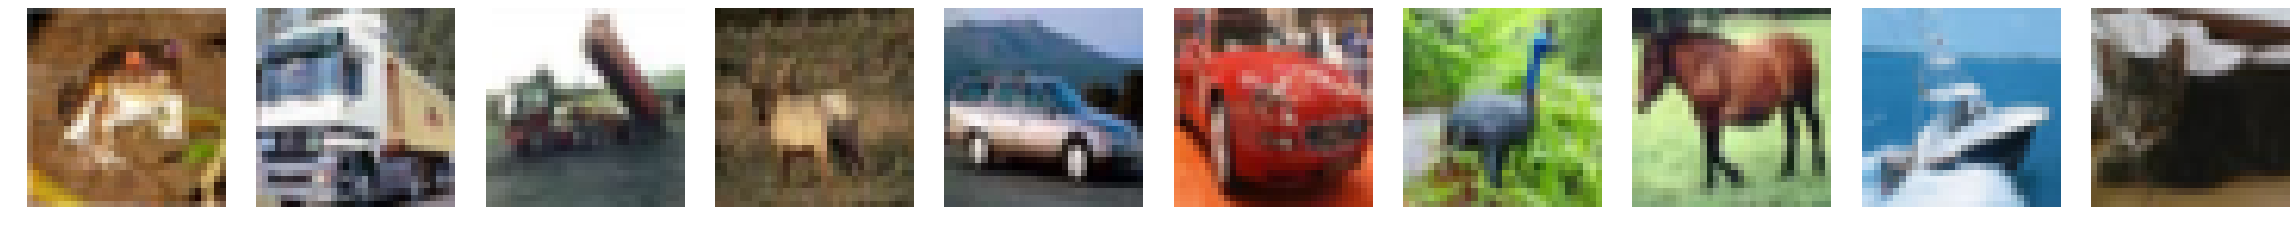

In [4]:
#plt.rcParams["figure.figsize"] = (1,1)

ncols = 10

fig, ax = plt.subplots(nrows = 1, ncols = ncols,figsize = (32,32))
for i in range(ncols):
    ax[i].imshow(x_train[i] )
    ax[i].axis('off')
    fig.tight_layout()
    
plt.show()
    

### Configure the hyperparameters

In [5]:
def init():
    return {"EPOCH" : 10, "SEED" : 42}

In [6]:
EPOCH = init()["EPOCH"] # DO NOT CHANGE THIS
SEED = init()["SEED"] # DO NOT CHANGE THIS
BATCH_SIZE = 64 #TODO: set hyperparameters (int)
CODINGS_SIZE = 350 #TODO: set parameters for the latent space representation (int)
LEARNING_RATE = 0.0001 #TODO: set hyperparameters (int)
IMG_SIZE = (32, 32, 3) #TODO: define the image size

In [7]:
#K = keras.backend
#tf.random.set_seed(SEED) # for reproduciable results
np.random.seed(SEED) # for reproduciable results

### Define the Model

In [8]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, CODINGS_SIZE))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [9]:
def encoder(i, c, *args, **kwargs):
    """
    function name:
        encoder() = to compress the image inputs (latent)
    function parameters:
        i = image size
        c = coding size
    """
    
    encoder_in = Input(name="input_1", shape=(32,32,3))   ##INPUT FOR THE IMAGE

    inputs = keras.layers.Input(name="input_1", shape=i)
    #TODO: define the layers stack for the encoder part. you may use MLP, LSTM, or CNN.
    # variable 'z' will be the first layer
    # z = ...

    z = Conv2D(16, 5, strides=2, padding="same", name='conv_1')(inputs)
    z = BatchNormalization(name='bn_1')(z)
    z = LeakyReLU(0.1, name='l_relu_1')(z)

    z = Conv2D(16, 5, strides=2, padding="same", name='conv_2')(z)
    z = BatchNormalization(name='bn_2')(z)
    z = LeakyReLU(0.1, name='l_relu_2')(z)
    
    #z = Conv2D(8, 5, strides=2, padding="same", name='conv_3')(z)
    #z = BatchNormalization(name='bn_3')(z)
    #z = LeakyReLU(0.1, name='l_relu_3')(z)
    
    #z = Conv2D(256, 5, strides=2, padding="same", name='conv_4')(z)
    #z = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001, name='bn_4')(z)
    #z = LeakyReLU(name='l_relu_4')(z)
    
    #z = Conv2D(512, 5, strides=2, padding="same", name='conv_5')(z)
    #z = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001, name='bn_5')(z)
    #z = LeakyReLU(name='l_relu_5')(z)

    z = Flatten(name='flatten_')(z)
    z = Dense(c, name='dense_1')(z)

    codings_mean = keras.layers.Dense(c, name='dense_2')(z)
    codings_log_var = keras.layers.Dense(c, name='dense_3')(z)
    codings = Sampling(name='sampling_')([codings_mean, codings_log_var])
    
    #z = Sampling()([z_mean, z_log_var])
    model = Model(inputs, [codings_mean, codings_log_var, codings], name="encoder")
    #encoder.summary()
    
    return model, inputs, codings_mean, codings_log_var

In [10]:
def decoder(i, c, *args, **kwargs):
    """
    function name:
        decoder = to reconstruct the image (with the same size) from the compressed version (latent)
    function parameters:
        i = image size
        c = coding size
    """
    # decoder_inputs = keras.layers.Input(shape=[..., ..., c])
    #TODO: define the layers stack for the decoder part. you may use MLP, LSTM, or CNN.
    # variable 'x' will be the first layer
    # x = ...
    
    decoder_inputs = keras.Input(name="input_1", shape=(c, ))
    
    x = Dense(4 * 4 * 64, name="dense_1", activation="relu")(decoder_inputs)
    x = BatchNormalization(name='bn_0')(x)
    x = LeakyReLU(0.1, name='l_relu_0')(x)
    x = Reshape((4, 4, 64), name="reshape_")(x)

    x = Conv2DTranspose(128, 5, strides=2, padding="same", name="conv_transpose_1")(x)
    x = BatchNormalization(name='bn_1')(x)
    x = LeakyReLU(0.1, name='l_relu_1')(x)

    x = Conv2DTranspose(64, 5, strides=2, padding="same", name="conv_transpose_2")(x)
    x = BatchNormalization(name='bn_2')(x)
    x = LeakyReLU(0.1, name='l_relu_2')(x)

    x = Conv2DTranspose(48, 5, strides=2, padding="same", name="conv_transpose_3")(x)
    x = BatchNormalization(name='bn_3')(x)
    x = LeakyReLU(0.2, name='l_relu_3')(x)
    
    #x = Conv2DTranspose(16, 4, strides=2, padding="same", name="conv_transpose_4")(x)
    #x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001, name='bn_4')(x)
    #x = LeakyReLU(0.2, name='l_relu_4')(x)
    

    outputs = Conv2DTranspose(3, 5, activation="sigmoid", padding="same")(x)
    model = Model(decoder_inputs, outputs, name="decoder")
    
    return model

In [11]:
variational_encoder, inputs, codings_mean, codings_log_var = encoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_encoder.summary() # keep the trainable params below 20,000 is advised

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 16, 16, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 16, 16, 16)   64          conv_1[0][0]                     
__________________________________________________________________________________________________
l_relu_1 (LeakyReLU)            (None, 16, 16, 16)   0           bn_1[0][0]                       
__________________________________________________________________________________________________
conv_2 (Co

In [12]:
variational_decoder = decoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_decoder.summary() # keep the trainable params below 20,000 is advised

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              359424    
_________________________________________________________________
bn_0 (BatchNormalization)    (None, 1024)              4096      
_________________________________________________________________
l_relu_0 (LeakyReLU)         (None, 1024)              0         
_________________________________________________________________
reshape_ (Reshape)           (None, 4, 4, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 8, 8, 128)         204928    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 8, 8, 128)         512       
__________

In [13]:
z_mean, z_log_var, codings = variational_encoder(inputs)

reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#variational_ae.add_loss(K.mean(latent_loss) / (keras.backend.prod(IMG_SIZE)))

In [14]:
variational_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 350), (None, 350) 612210    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         854723    
Total params: 1,466,933
Trainable params: 1,464,341
Non-trainable params: 2,592
_________________________________________________________________


### Compile the model

In [15]:
def accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(K.round(y_true), K.round(y_pred))

def reconstruction_loss(y_true, y_pred):
    #return K.sum(K.binary_crossentropy(y_true, y_pred))
    return 100 * K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help

In [16]:
variational_ae.compile(
    optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), 
    loss=vae_loss , 
    metrics=[reconstruction_loss, kl_loss, accuracy]
)

### Train the model
* <b>Bechmark:</b> Validation accuracy fell at `91.48%` within 10 epochs.
* If you encounter this `WARNING:tensorflow:AutoGraph ...` in the first epoch, please ignore.

In [17]:
history = variational_ae.fit(
    x_train_norm, 
    x_train_norm, 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    validation_data=(x_test_norm, x_test_norm)
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 349us/step - loss: 2.4518 - reconstruction_loss: 2.4035 - kl_loss: 1.6097 - accuracy: 0.8075 - val_loss: 1.5197 - val_reconstruction_loss: 1.4514 - val_kl_loss: 2.2755 - val_accuracy: 0.8590
Epoch 2/10
50000/50000 [==============================] - 13s 261us/step - loss: 1.3592 - reconstruction_loss: 1.2922 - kl_loss: 2.2319 - accuracy: 0.8665 - val_loss: 1.1755 - val_reconstruction_loss: 1.1073 - val_kl_loss: 2.2725 - val_accuracy: 0.8774
Epoch 3/10
50000/50000 [==============================] - 13s 261us/step - loss: 1.1615 - reconstruction_loss: 1.0940 - kl_loss: 2.2503 - accuracy: 0.8785 - val_loss: 1.0645 - val_reconstruction_loss: 0.9959 - val_kl_loss: 2.2843 - val_accuracy: 0.8870
Epoch 4/10
50000/50000 [==============================] - 13s 260us/step - loss: 1.0406 - reconstruction_loss: 0.9727 - kl_loss: 2.2639 - accuracy: 0.8867 - val_loss: 0.9228 - val_reconstruct

### Visualize training and validation results

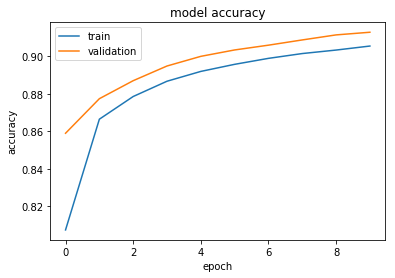

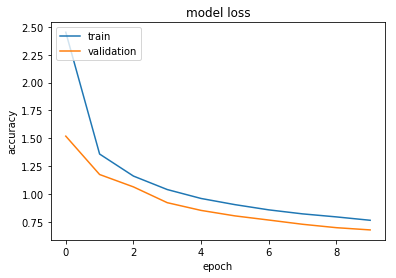

In [18]:
x_iter = [i for i in range(EPOCH)]
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


plt.plot(x_iter, train_acc)
plt.plot(x_iter, val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(x_iter, train_loss)
plt.plot(x_iter, val_loss)
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test the model

In [19]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

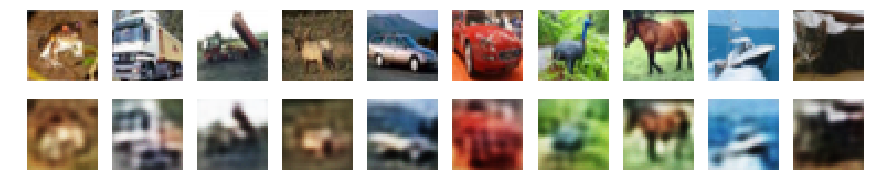

In [20]:
show_reconstructions(variational_ae, x_train_norm, n_images=10)

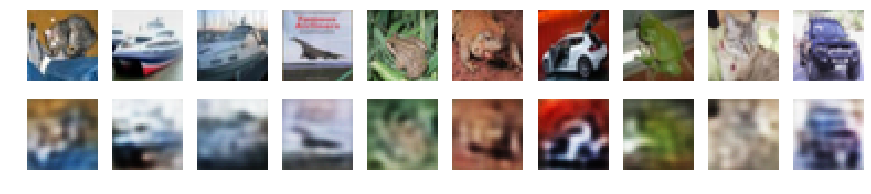

In [21]:
show_reconstructions(variational_ae, x_test_norm, n_images=10)

### Copyright 2022 PT. Agriaku Digital Indonesia
* You may NOT use this file except there is written permission from AgriAku.
* Any questions can be address to `nicholas.dominic@agriaku.com`.